## Weights Calculation
 Weight0: Every Gene weighted equally 
 
 Weight1: Ralitive Risk
 
 Weight2: Number of Hits
 
 Weight3: LofZ

In [82]:
%load_ext autoreload
%autoreload 2
from ASD_Circuits import *
from venn import venn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
# Load Gene INFO
HGNC = pd.read_csv("/Users/jiayao/Work/Resources/protein-coding_gene.txt", delimiter="\t")
ENSID2Entrez = dict(zip(HGNC["ensembl_gene_id"].values, HGNC["entrez_id"].values))
GeneSymbol2Entrez = dict(zip(HGNC["symbol"].values, HGNC["entrez_id"].values))
Entrez2Symbol = dict(zip(HGNC["entrez_id"].values, HGNC["symbol"].values))
allen_mouse_genes = loadgenelist("../dat/allen-mouse-exp/allen-mouse-gene_entrez.txt")

# Load Exp Zscore Matrix
ExpMat = "../dat/allen-mouse-exp/energy-conn-model.csv"
ExpMat = pd.read_csv(ExpMat, index_col="ROW")

ExpZscoreMat = "../dat/allen-mouse-exp/energy-zscore-conn-model.csv"
ExpZscoreMat = pd.read_csv(ExpZscoreMat, index_col="ROW")

ExpMatNorm = "../dat/allen-mouse-exp/energy-neuronorm.csv"
ExpMatNorm = pd.read_csv(ExpMatNorm, index_col="ROW")

ExpZscoreMatNorm = "../dat/allen-mouse-exp/energy-zscore-neuronorm.csv"
ExpZscoreMatNorm = pd.read_csv(ExpZscoreMatNorm, index_col="ROW")

allen_mouse_genes = loadgenelist("/Users/jiayao/Work/ASD_Circuits/dat/allen-mouse-exp/allen-mouse-gene_entrez.txt")

gnomad_cons = pd.read_csv("/Users/jiayao/Work/Resources/gnomad.v2.1.1.lof_metrics.by_gene.txt",
                          delimiter="\t", index_col="gene")

/Users/jiayao/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (38,48) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# SSC

In [85]:
ssc_lowIQ.head(2)

,Entrez,Gene,dnLGD,dnMis,FDR
0,3909,LAMA3,0,1,0.000
1,84918,LRP11,0,1,0.008


In [91]:
ssc_highIQ = pd.read_csv("../dat/genes/asd/ssc_highIQ.csv")
ssc_lowIQ = pd.read_csv("../dat/genes/asd/ssc_LowIQ.csv")
ssc_match_df = pd.read_csv("dat/matching/asd_ssc_exp_matches_1000.csv", index_col="GENE")

ssc_lowIQ_gene2MutN = SSC_Gene_Weights(ssc_lowIQ, gnomad_cons, FDR=0.8)
ssc_highIQ_gene2MutN = SSC_Gene_Weights(ssc_highIQ, gnomad_cons, FDR=0.8)

In [92]:
ssc_match_df.index.values

array([ 29123,  10438,   1826,   4297,   8295,  55870,  57680,   2904,
        23389,   6326,   1106,   4851,  23135,   2194,    463,   6711,
        23001,   7204,  53335,  57492,   8831,   7994,   1859,  10787,
        57451,   9578,  79633,   4041,  23654,   2200,  51322,  84629,
        58508,  23199,  26960,  58499,  22859, 493901,   6683,  22941,
         8085,  57634,  80816,  10716,  51366,  27245,   5728,  84444,
         5253,  28514,   9994,   9969,   4627,   5430,  23036,   6710,
        55777,  55636,  23112,  26057,   7249,  57453,   9620, 283450,
        23469,   6305,   2975,  64207,   2033,   6323,  25831,  23394,
        23405,  84181,   4849,   3897,  26011,  26058,   1956,   9378,
        25942,    394,   3608,  26046,   6651,   7468,    777,   1938,
         2901,   9901,  23152,  23030,   9020,  11083,   5361,  23352,
         8912,  85445,   7874,   9044, 112939,   5980,  23013,   9228,
         9024, 152789, 116931,   7477,   1387,     29,   4739,   6601,
      

In [98]:
len(ssc_lowIQ_gene2MutN.keys())
ssc_lowIQ_gene2MutN.keys()

dict_keys([23040, 57492, 8500, 23352, 2562, 7994, 55870, 7874, 27086, 51317, 9578, 1859, 27245, 4739, 10716, 10847, 11198, 57680, 481, 26058, 64207, 9536, 8697, 7477, 5990, 4849, 8085, 25942, 1826, 29123, 26512, 7090, 152789, 6305, 2904, 5728, 7014, 26115, 287, 23654, 23389, 10087, 2626, 55167, 23126, 51322, 1106, 1995, 79718, 1778, 6323, 394, 57451, 1499, 28514, 26057, 9320, 29, 777, 26130, 2972, 6326, 3608, 23053, 26040, 10743, 9994, 5133, 53335, 23179, 91752, 3897, 27154, 51684, 23469, 6529, 8239, 8912, 9901, 7204, 4292, 8831, 9372])

In [97]:
len(ssc_highIQ_gene2MutN.keys())

174

In [103]:
ssc_hiq_explevel_Mutcount = ExpAVGWithExpMatch(ExpMat, ssc_highIQ_gene2MutN, ssc_match_df,
                                              csv_fil = "dat/bias/ssc.highIQ.explevel.weighted.Mutcount.bias.csv")
RegionDistributions(ssc_hiq_explevel_Mutcount.set_index("STR"))

Hippocampal_formation 	 3 	 Subiculum_dorsal_part; Postsubiculum; Parasubiculum
Cortical_subplate 	 1 	 Posterior_amygdalar_nucleus
Olfactory_areas 	 5 	 Accessory_olfactory_bulb; Anterior_olfactory_nucleus; Main_olfactory_bulb; Dorsal_peduncular_area; Taenia_tecta
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA3; Field_CA2; Field_CA1
Thalamus 	 10 	 Lateral_posterior_nucleus_of_the_thalamus; Parataenial_nucleus; Central_lateral_nucleus_of_the_thalamus; Lateral_dorsal_nucleus_of_thalamus; Parafascicular_nucleus; Anteromedial_nucleus_dorsal_part; Mediodorsal_nucleus_of_thalamus; Lateral_habenula; Dorsal_part_of_the_lateral_geniculate_complex; Nucleus_of_reuniens
Isocortex 	 16 	 Orbital_area_ventrolateral_part; Infralimbic_area; Orbital_area_lateral_part; Frontal_pole_cerebral_cortex; Retrosplenial_area_lateral_agranular_part; Secondary_motor_area; Anteromedial_visual_area; Primary_visual_area; Retrosplenial_area_dorsal_part; Agranular_insular_area_ventral_part; Posterolateral_visual_a

In [104]:
ssc_liq_explevel_Mutcount = ExpAVGWithExpMatch(ExpMat, ssc_lowIQ_gene2MutN, ssc_match_df,
                                              csv_fil = "dat/bias/ssc.lowIQ.explevel.weighted.Mutcount.bias.csv")
RegionDistributions(ssc_liq_explevel_Mutcount.set_index("STR"))

Hippocampal_formation 	 4 	 Parasubiculum; Subiculum_ventral_part; Presubiculum; Postsubiculum
Cortical_subplate 	 4 	 Endopiriform_nucleus_dorsal_part; Basomedial_amygdalar_nucleus; Claustrum; Basolateral_amygdalar_nucleus
Olfactory_areas 	 6 	 Anterior_olfactory_nucleus; Accessory_olfactory_bulb; Dorsal_peduncular_area; Piriform_area; Taenia_tecta; Piriform_amygdalar_area
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA2; Field_CA3; Field_CA1
Thalamus 	 2 	 Lateral_posterior_nucleus_of_the_thalamus; Nucleus_of_reuniens
Isocortex 	 26 	 Prelimbic_area; Infralimbic_area; Orbital_area_lateral_part; Anterior_cingulate_area_dorsal_part; Orbital_area_ventrolateral_part; Anterior_cingulate_area_ventral_part; Lateral_visual_area; Retrosplenial_area_lateral_agranular_part; Retrosplenial_area_dorsal_part; Secondary_motor_area; Primary_somatosensory_area_lower_limb; Primary_somatosensory_area_upper_limb; Anteromedial_visual_area; Agranular_insular_area_ventral_part; Temporal_association_areas; 

## ASC

In [76]:
asc_df = pd.read_csv("../dat/genes/asd/asc_tada_RR.csv")
gene_classifier = pd.read_excel("../dat/genes/1-s2.0-S0092867419313984-mmc4.xlsx", sheet_name="Heterogeneity")
gene_classifier = gene_classifier.head(102)
ASDp_genes = gene_classifier[gene_classifier["classifier"]=="ASD_P"]["gene"].values
ASD_NDD_genes = gene_classifier[gene_classifier["classifier"]=="ASD_NDD"]["gene"].values
asc_asdp = asc_df[asc_df["gene"].isin(ASDp_genes)]
asc_asdndd = asc_df[asc_df["gene"].isin(ASD_NDD_genes)]

In [75]:
asc_df.head(2)

,gene,hugoGene,hgnc_id,entrez_id,ensembl_gene_id,refseq_accession,uniprot_ids,location,chr,start_hg38,...,ASC65_2015,ASC102_2018,ASD:DDID,ASD_vs_DDID,ASD53,DDID49,Function,LGD_RR,misa_RR,misb_RR
0,CHD8,CHD8,HGNC:20153,57680,ENSG00000100888,NM_020920,Q9HCK8,14q11.2,chr14,21385194,...,1,1,3.07850705163288,ASD,1,0,Gene expression regulation,60.711380,12.347005,15.270008
1,SCN2A,SCN2A,HGNC:10588,6326,ENSG00000136531,NM_021007,Q99250,2q24.3,chr2,165194993,...,1,1,0.6913147929608191,DDID,0,1,Neuronal communication,80.483746,6.916012,36.717196


In [78]:
asc_asdp_gene2MutN = ASC_Gene_Weights(asc_asdp, gnomad_cons, FDR=0.1)
asc_asdndd_gene2MutN = ASC_Gene_Weights(asc_asdndd, gnomad_cons, FDR=0.1)

In [79]:
asc_asdp_explevel_Mutcount = ExpAVGWithExpMatch(ExpMat, asc_asdp_gene2MutN, asd_asc_match_df,
                                              csv_fil = "dat/bias/asc.asdp.explevel.weighted.Mutcount.bias.csv")
RegionDistributions(asc_asdp_explevel_Mutcount.set_index("STR"))

Hippocampal_formation 	 3 	 Postsubiculum; Parasubiculum; Subiculum_dorsal_part
Hypothalamus 	 1 	 Medial_preoptic_nucleus
Olfactory_areas 	 3 	 Anterior_olfactory_nucleus; Accessory_olfactory_bulb; Piriform_amygdalar_area
Hippocampal_region 	 2 	 Dentate_gyrus; Field_CA2
Thalamus 	 12 	 Lateral_posterior_nucleus_of_the_thalamus; Ventral_posteromedial_nucleus_of_the_thalamus_parvicellular_part; Parafascicular_nucleus; Posterior_complex_of_the_thalamus; Subparafascicular_nucleus_magnocellular_part; Parataenial_nucleus; Submedial_nucleus_of_the_thalamus; Lateral_dorsal_nucleus_of_thalamus; Rhomboid_nucleus; Mediodorsal_nucleus_of_thalamus; Central_medial_nucleus_of_the_thalamus; Central_lateral_nucleus_of_the_thalamus
Isocortex 	 22 	 Primary_visual_area; posteromedial_visual_area; Anterolateral_visual_area; Lateral_visual_area; Orbital_area_lateral_part; Primary_somatosensory_area_lower_limb; Posterolateral_visual_area; Retrosplenial_area_lateral_agranular_part; Retrosplenial_area_dorsa

In [80]:
asc_asdbdd_explevel_Mutcount = ExpAVGWithExpMatch(ExpMat, asc_asdndd_gene2MutN, asd_asc_match_df,
                                              csv_fil = "dat/bias/asc.asdndd.explevel.weighted.Mutcount.bias.csv")
RegionDistributions(asc_asdbdd_explevel_Mutcount.set_index("STR"))

Hippocampal_formation 	 4 	 Subiculum_ventral_part; Subiculum_dorsal_part; Entorhinal_area_lateral_part; Parasubiculum
Cortical_subplate 	 6 	 Lateral_amygdalar_nucleus; Endopiriform_nucleus_dorsal_part; Claustrum; Basolateral_amygdalar_nucleus; Endopiriform_nucleus_ventral_part; Basomedial_amygdalar_nucleus
Olfactory_areas 	 7 	 Dorsal_peduncular_area; Anterior_olfactory_nucleus; Piriform_area; Accessory_olfactory_bulb; Taenia_tecta; Piriform_amygdalar_area; Postpiriform_transition_area
Hippocampal_region 	 4 	 Field_CA1; Field_CA2; Dentate_gyrus; Field_CA3
Thalamus 	 2 	 Lateral_posterior_nucleus_of_the_thalamus; Nucleus_of_reuniens
Isocortex 	 25 	 Prelimbic_area; Infralimbic_area; Retrosplenial_area_lateral_agranular_part; Anteromedial_visual_area; Orbital_area_ventrolateral_part; Orbital_area_medial_part; Orbital_area_lateral_part; Anterior_cingulate_area_dorsal_part; Secondary_motor_area; Posterior_parietal_association_areas; Lateral_visual_area; Primary_somatosensory_area_lower_

In [48]:
asc_gene2None, asc_gene2RR, asc_gene2MutN, asc_gene2Cons, asc_gene2MutNLofZ, asc_gene2MutNQValue = ASC_Gene_Weights(
    "../dat/genes/asd/asc_tada_RR.csv", gnomad_cons, FDR=0.1)
asd_asc_match_df = pd.read_csv("dat/matching/asd_asc_exp_matches_1000.csv", index_col="GENE")
print("Number of genes: %d"%len(asc_gene2RR))
asc_gene2MutN_Length = ASC_MutCountByLength(
    "../dat/genes/asd/asc_tada_RR.csv", 
    "/Users/jiayao/Work/ASD_Circuits/src/dat/match-features.csv" , FDR=0.1)

Number of genes: 102
27086
23126
287
93986


In [65]:
asc_explevel_Mutcount = ExpAVGWithExpMatch(ExpMat, asc_gene2MutN, asd_asc_match_df,
                                              csv_fil = "dat/bias/asc.explevel.weighted.Mutcount.bias.csv")
RegionDistributions(asc_explevel_Mutcount.set_index("STR"))

Hippocampal_formation 	 4 	 Subiculum_dorsal_part; Subiculum_ventral_part; Parasubiculum; Entorhinal_area_lateral_part
Cortical_subplate 	 3 	 Lateral_amygdalar_nucleus; Endopiriform_nucleus_dorsal_part; Claustrum
Olfactory_areas 	 6 	 Anterior_olfactory_nucleus; Dorsal_peduncular_area; Accessory_olfactory_bulb; Piriform_amygdalar_area; Taenia_tecta; Piriform_area
Hippocampal_region 	 4 	 Field_CA2; Dentate_gyrus; Field_CA1; Field_CA3
Thalamus 	 5 	 Lateral_posterior_nucleus_of_the_thalamus; Rhomboid_nucleus; Mediodorsal_nucleus_of_thalamus; Nucleus_of_reuniens; Parafascicular_nucleus
Isocortex 	 25 	 Prelimbic_area; Retrosplenial_area_lateral_agranular_part; Orbital_area_lateral_part; Infralimbic_area; Anteromedial_visual_area; Orbital_area_ventrolateral_part; Lateral_visual_area; Primary_visual_area; Orbital_area_medial_part; Anterior_cingulate_area_dorsal_part; Primary_somatosensory_area_lower_limb; Posterior_parietal_association_areas; posteromedial_visual_area; Secondary_motor_are

In [66]:
asc_explevel_norm_Mutcount = ExpAVGWithExpMatch(ExpMatNorm, asc_gene2MutN, asd_asc_match_df,
                                              csv_fil = "dat/bias/asc.norm.explevel.weighted.Mutcount.bias.csv")
RegionDistributions(asc_explevel_norm_Mutcount.set_index("STR"))

Hippocampal_formation 	 5 	 Subiculum_dorsal_part; Subiculum_ventral_part; Postsubiculum; Entorhinal_area_lateral_part; Parasubiculum
Cortical_subplate 	 3 	 Claustrum; Endopiriform_nucleus_dorsal_part; Lateral_amygdalar_nucleus
Olfactory_areas 	 6 	 Anterior_olfactory_nucleus; Dorsal_peduncular_area; Accessory_olfactory_bulb; Piriform_amygdalar_area; Taenia_tecta; Piriform_area
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA2; Field_CA1; Field_CA3
Thalamus 	 3 	 Lateral_posterior_nucleus_of_the_thalamus; Parafascicular_nucleus; Submedial_nucleus_of_the_thalamus
Isocortex 	 25 	 Prelimbic_area; Infralimbic_area; Orbital_area_lateral_part; Anteromedial_visual_area; Retrosplenial_area_lateral_agranular_part; Orbital_area_ventrolateral_part; Primary_visual_area; Anterior_cingulate_area_dorsal_part; Primary_somatosensory_area_lower_limb; Posterior_parietal_association_areas; posteromedial_visual_area; Orbital_area_medial_part; Posterolateral_visual_area; Anterior_cingulate_area_ventral_pa

In [67]:
asc_avgZ_Mutcount = AvgSTRZ_Weighted(ExpZscoreMat, asc_gene2MutN,
                                              csv_fil = "dat/bias/asc.avgZ.weighted.Mutcount.bias.csv")
RegionDistributions(asc_avgZ_Mutcount.set_index("STR"))

Hippocampal_formation 	 3 	 Subiculum_dorsal_part; Subiculum_ventral_part; Parasubiculum
Cortical_subplate 	 5 	 Endopiriform_nucleus_dorsal_part; Claustrum; Lateral_amygdalar_nucleus; Basomedial_amygdalar_nucleus; Endopiriform_nucleus_ventral_part
Olfactory_areas 	 3 	 Piriform_area; Anterior_olfactory_nucleus; Dorsal_peduncular_area
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA2; Field_CA3
Thalamus 	 7 	 Lateral_posterior_nucleus_of_the_thalamus; Parafascicular_nucleus; Mediodorsal_nucleus_of_thalamus; Lateral_dorsal_nucleus_of_thalamus; Submedial_nucleus_of_the_thalamus; Central_lateral_nucleus_of_the_thalamus; Nucleus_of_reuniens
Isocortex 	 18 	 Prelimbic_area; Primary_somatosensory_area_lower_limb; Posterior_parietal_association_areas; Infralimbic_area; Anteromedial_visual_area; Primary_visual_area; Primary_motor_area; Anterior_cingulate_area_dorsal_part; Retrosplenial_area_lateral_agranular_part; Secondary_motor_area; Orbital_area_lateral_part; Anterior_cingulate_a

In [68]:
asc_avgZ_norm_Mutcount = AvgSTRZ_Weighted(ExpZscoreMatNorm, asc_gene2MutN,
                                              csv_fil = "dat/bias/asc.norm.avgZ.weighted.Mutcount.bias.csv")
RegionDistributions(asc_avgZ_norm_Mutcount.set_index("STR"))

Hippocampal_formation 	 5 	 Subiculum_dorsal_part; Subiculum_ventral_part; Postsubiculum; Parasubiculum; Presubiculum
Cortical_subplate 	 3 	 Claustrum; Endopiriform_nucleus_dorsal_part; Basomedial_amygdalar_nucleus
Olfactory_areas 	 4 	 Anterior_olfactory_nucleus; Dorsal_peduncular_area; Accessory_olfactory_bulb; Piriform_area
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA2; Field_CA1; Field_CA3
Thalamus 	 6 	 Lateral_posterior_nucleus_of_the_thalamus; Parafascicular_nucleus; Mediodorsal_nucleus_of_thalamus; Central_lateral_nucleus_of_the_thalamus; Submedial_nucleus_of_the_thalamus; Ventral_posteromedial_nucleus_of_the_thalamus_parvicellular_part
Isocortex 	 20 	 Prelimbic_area; Infralimbic_area; Orbital_area_lateral_part; Anteromedial_visual_area; Retrosplenial_area_lateral_agranular_part; Primary_visual_area; Orbital_area_ventrolateral_part; Anterior_cingulate_area_dorsal_part; Primary_somatosensory_area_lower_limb; Posterior_parietal_association_areas; Anterior_cingulate_area_ven

In [43]:
asc_specificity_MutNQ = AvgSTRZ_Weighted(ExpZscoreMat, asc_gene2MutNQValue, 
                                                         csv_fil="dat/bias/asc.avgZ.weighted.MutNQ.bias.csv")
RegionDistributions(asc_specificity_MutNQ.set_index("STR"))

Hippocampal_formation 	 5 	 Subiculum_dorsal_part; Postsubiculum; Presubiculum; Parasubiculum; Subiculum_ventral_part
Cortical_subplate 	 3 	 Claustrum; Endopiriform_nucleus_dorsal_part; Posterior_amygdalar_nucleus
Olfactory_areas 	 3 	 Piriform_area; Dorsal_peduncular_area; Taenia_tecta
Hippocampal_region 	 4 	 Field_CA2; Field_CA1; Dentate_gyrus; Field_CA3
Thalamus 	 1 	 Lateral_dorsal_nucleus_of_thalamus
Isocortex 	 29 	 Posterior_parietal_association_areas; posteromedial_visual_area; Primary_somatosensory_area_trunk; Anterior_cingulate_area_ventral_part; Retrosplenial_area_lateral_agranular_part; Primary_somatosensory_area_lower_limb; Primary_auditory_area; Primary_somatosensory_area_upper_limb; Primary_visual_area; Retrosplenial_area_ventral_part; Infralimbic_area; Ectorhinal_area; Agranular_insular_area_ventral_part; Primary_motor_area; Primary_somatosensory_area_mouth; Retrosplenial_area_dorsal_part; Anteromedial_visual_area; Temporal_association_areas; Gustatory_areas; Dorsal_a

In [45]:
asc_explevel_MutNQ = ExpAVGWithExpMatch(ExpMat, asc_gene2MutNQValue, asd_asc_match_df,
                                                         csv_fil="dat/bias/asc.explevel.weighted.MutNQ.bias.csv")
RegionDistributions(asc_explevel_MutNQ.set_index("STR"))

Hippocampal_formation 	 5 	 Subiculum_dorsal_part; Parasubiculum; Presubiculum; Postsubiculum; Entorhinal_area_medial_part_dorsal_zone
Cortical_subplate 	 1 	 Claustrum
Olfactory_areas 	 3 	 Piriform_amygdalar_area; Cortical_amygdalar_area_posterior_part; Dorsal_peduncular_area
Hippocampal_region 	 4 	 Field_CA2; Dentate_gyrus; Field_CA1; Field_CA3
Thalamus 	 8 	 Medial_habenula; Medial_geniculate_complex_dorsal_part; Intermediodorsal_nucleus_of_the_thalamus; Lateral_dorsal_nucleus_of_thalamus; Ventral_anterior_lateral_complex_of_the_thalamus; Anteroventral_nucleus_of_thalamus; Rhomboid_nucleus; Medial_geniculate_complex_ventral_part
Isocortex 	 23 	 Retrosplenial_area_lateral_agranular_part; posteromedial_visual_area; Primary_auditory_area; Anterior_cingulate_area_ventral_part; Posterior_parietal_association_areas; Primary_visual_area; Retrosplenial_area_ventral_part; Primary_somatosensory_area_trunk; Retrosplenial_area_dorsal_part; Anteromedial_visual_area; Ectorhinal_area; Infralimb

In [38]:
asc_specificity_MutNGL = AvgSTRZ_Weighted(ExpZscoreMat, asc_gene2MutN_Length, 
                                                         csv_fil="dat/bias/asc.avgZ.weighted.MutNGL.bias.csv")
RegionDistributions(asc_specificity_MutNGL.set_index("STR"))

Hippocampal_formation 	 4 	 Subiculum_dorsal_part; Subiculum_ventral_part; Parasubiculum; Presubiculum
Cortical_subplate 	 5 	 Endopiriform_nucleus_dorsal_part; Claustrum; Basomedial_amygdalar_nucleus; Lateral_amygdalar_nucleus; Endopiriform_nucleus_ventral_part
Olfactory_areas 	 3 	 Piriform_area; Anterior_olfactory_nucleus; Dorsal_peduncular_area
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA2; Field_CA3
Thalamus 	 7 	 Lateral_posterior_nucleus_of_the_thalamus; Mediodorsal_nucleus_of_thalamus; Parafascicular_nucleus; Lateral_dorsal_nucleus_of_thalamus; Submedial_nucleus_of_the_thalamus; Central_lateral_nucleus_of_the_thalamus; Nucleus_of_reuniens
Isocortex 	 18 	 Prelimbic_area; Primary_somatosensory_area_lower_limb; Posterior_parietal_association_areas; Primary_motor_area; Infralimbic_area; Anteromedial_visual_area; Anterior_cingulate_area_dorsal_part; Primary_somatosensory_area_trunk; Retrosplenial_area_lateral_agranular_part; Orbital_area_lateral_part; Primary_visual_

In [24]:
asc_explevel_MutNGL = ExpAVGWithExpMatch(ExpMat, asc_gene2MutN_Length, asd_asc_match_df,
                                              csv_fil = "dat/bias/asc.explevel.weighted.MutNGL.bias.csv")
RegionDistributions(asc_explevel_MutNGL.set_index("STR"))

Hippocampal_formation 	 5 	 Subiculum_dorsal_part; Subiculum_ventral_part; Parasubiculum; Entorhinal_area_lateral_part; Presubiculum
Cortical_subplate 	 5 	 Endopiriform_nucleus_dorsal_part; Claustrum; Lateral_amygdalar_nucleus; Basomedial_amygdalar_nucleus; Basolateral_amygdalar_nucleus
Olfactory_areas 	 6 	 Anterior_olfactory_nucleus; Dorsal_peduncular_area; Accessory_olfactory_bulb; Piriform_amygdalar_area; Piriform_area; Taenia_tecta
Hippocampal_region 	 4 	 Field_CA2; Dentate_gyrus; Field_CA1; Field_CA3
Thalamus 	 2 	 Lateral_posterior_nucleus_of_the_thalamus; Rhomboid_nucleus
Isocortex 	 26 	 Retrosplenial_area_lateral_agranular_part; Prelimbic_area; Orbital_area_lateral_part; Infralimbic_area; Anteromedial_visual_area; Orbital_area_ventrolateral_part; Lateral_visual_area; Primary_somatosensory_area_lower_limb; Anterior_cingulate_area_dorsal_part; Posterior_parietal_association_areas; Primary_visual_area; Retrosplenial_area_dorsal_part; Orbital_area_medial_part; Secondary_motor_a

In [25]:
asc_explevel_Mutcount = ExpAVGWithExpMatch(ExpMat, asc_gene2MutN, asd_asc_match_df,
                                              csv_fil = "dat/bias/asc.explevel.weighted.Mutcount.bias.csv")
RegionDistributions(asc_explevel_Mutcount.set_index("STR"))

Hippocampal_formation 	 4 	 Subiculum_dorsal_part; Subiculum_ventral_part; Parasubiculum; Entorhinal_area_lateral_part
Cortical_subplate 	 3 	 Lateral_amygdalar_nucleus; Endopiriform_nucleus_dorsal_part; Claustrum
Olfactory_areas 	 6 	 Anterior_olfactory_nucleus; Dorsal_peduncular_area; Accessory_olfactory_bulb; Piriform_amygdalar_area; Taenia_tecta; Piriform_area
Hippocampal_region 	 4 	 Field_CA2; Dentate_gyrus; Field_CA1; Field_CA3
Thalamus 	 5 	 Lateral_posterior_nucleus_of_the_thalamus; Rhomboid_nucleus; Mediodorsal_nucleus_of_thalamus; Nucleus_of_reuniens; Parafascicular_nucleus
Isocortex 	 25 	 Prelimbic_area; Retrosplenial_area_lateral_agranular_part; Orbital_area_lateral_part; Infralimbic_area; Anteromedial_visual_area; Orbital_area_ventrolateral_part; Lateral_visual_area; Primary_visual_area; Orbital_area_medial_part; Anterior_cingulate_area_dorsal_part; Primary_somatosensory_area_lower_limb; Posterior_parietal_association_areas; posteromedial_visual_area; Secondary_motor_are

In [83]:
RegionDistributions(asc_specificity_MutNTol.set_index("STR"))

Olfactory_areas 	 4 	 Piriform_area; Anterior_olfactory_nucleus; Dorsal_peduncular_area; Piriform_amygdalar_area
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA2; Field_CA3
Pallidum 	 2 	 Substantia_innominata; Bed_nuclei_of_the_stria_terminalis
Hippocampal_formation 	 4 	 Subiculum_dorsal_part; Subiculum_ventral_part; Parasubiculum; Presubiculum
Striatum 	 6 	 Nucleus_accumbens; Caudoputamen; Intercalated_amygdalar_nucleus; Lateral_septal_nucleus_ventral_part; Lateral_septal_nucleus_rostral_rostroventral_part; Lateral_septal_nucleus_caudal_caudodorsal_part
Cortical_subplate 	 5 	 Endopiriform_nucleus_dorsal_part; Claustrum; Basomedial_amygdalar_nucleus; Lateral_amygdalar_nucleus; Endopiriform_nucleus_ventral_part
Isocortex 	 15 	 Prelimbic_area; Primary_somatosensory_area_lower_limb; Posterior_parietal_association_areas; Infralimbic_area; Primary_motor_area; Orbital_area_lateral_part; Anteromedial_visual_area; Primary_somatosensory_area_trunk; Anterior_cingulate_area_dorsa

In [26]:
ExpMat.loc[1, "Anterior_amygdalar_area"]

0.08940160000000001

In [33]:
asc_explevel_Unifrom = ExpAVGWithExpMatch(ExpMat, asc_gene2None, asd_asc_match_df,
                                              csv_fil = "dat/bias/asc.explevel.weighted.Uniform.bias.csv")
RegionDistributions(asc_explevel_Unifrom.set_index("STR"))

Striatum 	 1 	 Nucleus_accumbens
Thalamus 	 4 	 Lateral_posterior_nucleus_of_the_thalamus; Lateral_dorsal_nucleus_of_thalamus; Medial_geniculate_complex_medial_part; Rhomboid_nucleus
Olfactory_areas 	 5 	 Anterior_olfactory_nucleus; Piriform_amygdalar_area; Accessory_olfactory_bulb; Dorsal_peduncular_area; Taenia_tecta
Isocortex 	 28 	 Retrosplenial_area_lateral_agranular_part; Prelimbic_area; Retrosplenial_area_dorsal_part; Anteromedial_visual_area; Orbital_area_ventrolateral_part; posteromedial_visual_area; Primary_visual_area; Posterior_parietal_association_areas; Orbital_area_lateral_part; Infralimbic_area; Primary_somatosensory_area_lower_limb; Anterior_cingulate_area_ventral_part; Anterior_cingulate_area_dorsal_part; Primary_somatosensory_area_trunk; Orbital_area_medial_part; Posterolateral_visual_area; Lateral_visual_area; Retrosplenial_area_ventral_part; Anterolateral_visual_area; Secondary_motor_area; Primary_somatosensory_area_upper_limb; Primary_motor_area; Perirhinal_area; 

In [35]:
asc_explevel_RR = ExpAVGWithExpMatch(ExpMat, asc_gene2RR, asd_asc_match_df,
                                              csv_fil = "dat/bias/asc.explevel.weighted.RR.bias.csv")
RegionDistributions(asc_explevel_RR.set_index("STR"))

Striatum 	 2 	 Nucleus_accumbens; Caudoputamen
Thalamus 	 1 	 Lateral_posterior_nucleus_of_the_thalamus
Olfactory_areas 	 4 	 Anterior_olfactory_nucleus; Dorsal_peduncular_area; Accessory_olfactory_bulb; Taenia_tecta
Isocortex 	 31 	 Prelimbic_area; Orbital_area_ventrolateral_part; Retrosplenial_area_lateral_agranular_part; Infralimbic_area; Orbital_area_lateral_part; Orbital_area_medial_part; Primary_visual_area; Anteromedial_visual_area; Anterior_cingulate_area_dorsal_part; posteromedial_visual_area; Retrosplenial_area_dorsal_part; Anterior_cingulate_area_ventral_part; Primary_somatosensory_area_lower_limb; Secondary_motor_area; Lateral_visual_area; Posterior_parietal_association_areas; Visceral_area; Anterolateral_visual_area; Posterolateral_visual_area; Perirhinal_area; Primary_motor_area; Retrosplenial_area_ventral_part; Frontal_pole_cerebral_cortex; Primary_somatosensory_area_trunk; Supplemental_somatosensory_area; Dorsal_auditory_area; Temporal_association_areas; Primary_somatos

In [93]:
asc_avgZ_RR = Weighted_ZscoreAVGWithExpMatch(ExpZscoreMat, asc_gene2RR, asd_asc_match_df,
                                              csv_fil = "dat/bias/asc.avgZ.weighted.RR.bias.csv")
RegionDistributions(asc_avgZ_RR.set_index("STR"))

Olfactory_areas 	 5 	 Anterior_olfactory_nucleus; Dorsal_peduncular_area; Piriform_area; Taenia_tecta; Accessory_olfactory_bulb
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA2; Field_CA3
Pallidum 	 1 	 Substantia_innominata
Hippocampal_formation 	 2 	 Subiculum_dorsal_part; Subiculum_ventral_part
Striatum 	 4 	 Nucleus_accumbens; Caudoputamen; Lateral_septal_nucleus_caudal_caudodorsal_part; Lateral_septal_nucleus_rostral_rostroventral_part
Cortical_subplate 	 3 	 Endopiriform_nucleus_dorsal_part; Lateral_amygdalar_nucleus; Claustrum
Isocortex 	 25 	 Prelimbic_area; Anterior_cingulate_area_dorsal_part; Infralimbic_area; Primary_somatosensory_area_lower_limb; Secondary_motor_area; Anteromedial_visual_area; Retrosplenial_area_lateral_agranular_part; Primary_visual_area; Anterior_cingulate_area_ventral_part; Posterior_parietal_association_areas; Primary_motor_area; Orbital_area_medial_part; Orbital_area_lateral_part; posteromedial_visual_area; Orbital_area_ventrolateral_part; 

In [ ]:
xx = 

In [36]:
asc_avgZ_Uniform = AvgSTRZ_Weighted(ExpMat, asc_gene2None, Match_DF=1,
                                              csv_fil = "dat/bias/asc.avgZ.weighted.Uniform.bias.csv")
RegionDistributions(asc_avgZ_Uniform.set_index("STR"))

Hippocampal_formation 	 2 	 Entorhinal_area_lateral_part; Subiculum_ventral_part
Cortical_subplate 	 6 	 Basolateral_amygdalar_nucleus; Lateral_amygdalar_nucleus; Posterior_amygdalar_nucleus; Basomedial_amygdalar_nucleus; Endopiriform_nucleus_dorsal_part; Claustrum
Olfactory_areas 	 4 	 Accessory_olfactory_bulb; Dorsal_peduncular_area; Piriform_area; Postpiriform_transition_area
Hippocampal_region 	 2 	 Dentate_gyrus; Field_CA3
Thalamus 	 1 	 Dorsal_part_of_the_lateral_geniculate_complex
Isocortex 	 35 	 Perirhinal_area; Lateral_visual_area; Ventral_auditory_area; Primary_auditory_area; Anterolateral_visual_area; Temporal_association_areas; Dorsal_auditory_area; Agranular_insular_area_posterior_part; Primary_motor_area; Gustatory_areas; Primary_somatosensory_area_lower_limb; Agranular_insular_area_dorsal_part; Posterior_parietal_association_areas; Anterior_cingulate_area_dorsal_part; Visceral_area; Primary_somatosensory_area_upper_limb; Primary_somatosensory_area_barrel_field; Agranula

In [51]:
asc_avgZ_Mutcount = AvgSTRZ_Weighted(ExpMat, asc_gene2MutN, Match_DF=1,
                                              csv_fil = "dat/bias/asc.avgZ.weighted.Mutcount.bias.csv")
RegionDistributions(asc_avgZ_Mutcount.set_index("STR"))

Olfactory_areas 	 4 	 Accessory_olfactory_bulb; Dorsal_peduncular_area; Piriform_area; Postpiriform_transition_area
Isocortex 	 35 	 Lateral_visual_area; Agranular_insular_area_posterior_part; Anterolateral_visual_area; Perirhinal_area; Temporal_association_areas; Ventral_auditory_area; Primary_auditory_area; Dorsal_auditory_area; Visceral_area; Gustatory_areas; Primary_motor_area; Prelimbic_area; Primary_somatosensory_area_lower_limb; Agranular_insular_area_dorsal_part; Anterior_cingulate_area_dorsal_part; Posterior_parietal_association_areas; Agranular_insular_area_ventral_part; Supplemental_somatosensory_area; Anteromedial_visual_area; Orbital_area_lateral_part; Primary_somatosensory_area_upper_limb; Primary_somatosensory_area_barrel_field; Primary_somatosensory_area_mouth; Primary_somatosensory_area_trunk; Primary_somatosensory_area_nose; Secondary_motor_area; Orbital_area_ventrolateral_part; Orbital_area_medial_part; Infralimbic_area; Posterolateral_visual_area; Ectorhinal_area; R

In [94]:
asc_avgZ_Mutcount = Weighted_ZscoreAVGWithExpMatch(ExpMat, asc_gene2MutN, asd_asc_match_df,
                                              csv_fil = "dat/bias/asc.avgZ.weighted.Mutcount.bias.csv")
RegionDistributions(asc_avgZ_Mutcount.set_index("STR"))

Olfactory_areas 	 4 	 Accessory_olfactory_bulb; Dorsal_peduncular_area; Piriform_area; Postpiriform_transition_area
Hippocampal_region 	 2 	 Dentate_gyrus; Field_CA3
Hippocampal_formation 	 2 	 Entorhinal_area_lateral_part; Subiculum_ventral_part
Cortical_subplate 	 7 	 Lateral_amygdalar_nucleus; Basolateral_amygdalar_nucleus; Posterior_amygdalar_nucleus; Basomedial_amygdalar_nucleus; Endopiriform_nucleus_dorsal_part; Claustrum; Endopiriform_nucleus_ventral_part
Isocortex 	 35 	 Lateral_visual_area; Agranular_insular_area_posterior_part; Anterolateral_visual_area; Perirhinal_area; Temporal_association_areas; Ventral_auditory_area; Primary_auditory_area; Dorsal_auditory_area; Visceral_area; Gustatory_areas; Primary_motor_area; Prelimbic_area; Primary_somatosensory_area_lower_limb; Agranular_insular_area_dorsal_part; Anterior_cingulate_area_dorsal_part; Posterior_parietal_association_areas; Agranular_insular_area_ventral_part; Supplemental_somatosensory_area; Anteromedial_visual_area; Or

In [95]:
asc_avgZ_Mutcount2 = Weighted_ZscoreAVGWithExpMatch(ExpMat, asc_gene2MutN, asd_asc_match_df, BootstrapeWeights=True,
                                              csv_fil = "dat/bias/asc.avgZ.weighted.Mutcount.bias.csv")
RegionDistributions(asc_avgZ_Mutcount2.set_index("STR"))

Olfactory_areas 	 4 	 Accessory_olfactory_bulb; Dorsal_peduncular_area; Piriform_area; Postpiriform_transition_area
Hippocampal_region 	 2 	 Dentate_gyrus; Field_CA3
Hippocampal_formation 	 2 	 Entorhinal_area_lateral_part; Subiculum_ventral_part
Cortical_subplate 	 7 	 Lateral_amygdalar_nucleus; Basolateral_amygdalar_nucleus; Posterior_amygdalar_nucleus; Basomedial_amygdalar_nucleus; Endopiriform_nucleus_dorsal_part; Claustrum; Endopiriform_nucleus_ventral_part
Isocortex 	 35 	 Lateral_visual_area; Agranular_insular_area_posterior_part; Anterolateral_visual_area; Perirhinal_area; Temporal_association_areas; Ventral_auditory_area; Primary_auditory_area; Dorsal_auditory_area; Visceral_area; Gustatory_areas; Primary_motor_area; Prelimbic_area; Primary_somatosensory_area_lower_limb; Agranular_insular_area_dorsal_part; Anterior_cingulate_area_dorsal_part; Posterior_parietal_association_areas; Agranular_insular_area_ventral_part; Supplemental_somatosensory_area; Anteromedial_visual_area; Or

In [31]:
asc_explevel_LofZ = ExpressionLevelWeightedBias(ExpMat, asc_gene2LofZ, asd_asc_match_df,
                                              csv_fil = "dat/bias/asc.explevel.weighted.LofZ.bias.csv")
RegionDistributions(asc_explevel_LofZ.set_index("STR"))

Olfactory_areas 	 7 	 Piriform_amygdalar_area; Anterior_olfactory_nucleus; Accessory_olfactory_bulb; Dorsal_peduncular_area; Taenia_tecta; Cortical_amygdalar_area_posterior_part; Piriform_area
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA2; Field_CA3
Hippocampal_formation 	 4 	 Subiculum_dorsal_part; Parasubiculum; Postsubiculum; Presubiculum
Striatum 	 2 	 Nucleus_accumbens; Olfactory_tubercle
Cortical_subplate 	 2 	 Claustrum; Endopiriform_nucleus_dorsal_part
Isocortex 	 23 	 Retrosplenial_area_lateral_agranular_part; Retrosplenial_area_dorsal_part; Prelimbic_area; Infralimbic_area; Posterior_parietal_association_areas; Primary_somatosensory_area_lower_limb; Orbital_area_lateral_part; Anteromedial_visual_area; Orbital_area_ventrolateral_part; Primary_somatosensory_area_trunk; Primary_visual_area; Anterior_cingulate_area_dorsal_part; Anterior_cingulate_area_ventral_part; posteromedial_visual_area; Posterolateral_visual_area; Orbital_area_medial_part; Primary_motor_area; 

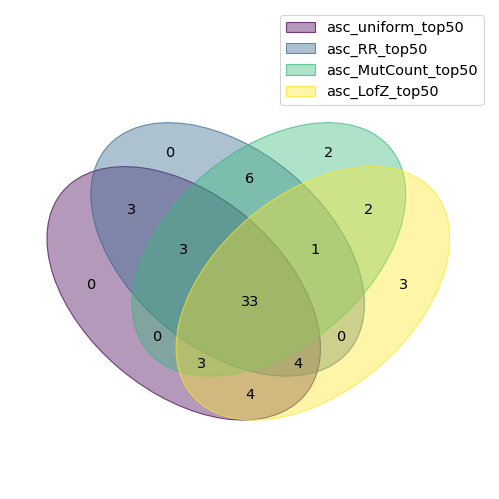

In [46]:
#asc_zmatch_bias = pd.read_csv("dat/bias/asd.asc.zmatch.rank.csv", index_col="STR")
#asc_elevel_bias = pd.read_csv("dat/bias/asc.explevel.rank.tsv", index_col="STR")
#spark_zmatch_bias = pd.read_csv("dat/bias/asd.sparktada.zmatch.rank.csv", index_col="STR")
#spark_elevel_bias = pd.read_csv("dat/bias/sparktada.explevel.rank.tsv", index_col="STR")
asc_uniform_top50 = set(asc_explevel_Unifrom.head(50).index.values)
asc_RR_top50 = set(asc_explevel_RR.head(50).index.values)
asc_MutCount_top50 = set(asc_explevel_Mutcount.head(50).index.values)
asc_LofZ_top50 = set(asc_explevel_LofZ.head(50).index.values)
dat_dict = {"asc_uniform_top50": asc_uniform_top50, "asc_RR_top50":asc_RR_top50, 
            "asc_MutCount_top50": asc_MutCount_top50, "asc_LofZ_top50":asc_LofZ_top50}
venn(dat_dict)

## SPARK TADA

In [57]:
spark_tada = pd.read_csv("../dat/genes/asd/spark_tada_RR.csv")
print(spark_tada.columns.values)

['GeneID' 'HGNC' 'ExACpLI' 'gnomADpLI' 'LoFOvsE' 'sHet' 'SFARICategory'
 'SFARIScore' 'DDDCategory' 'DDDAllelic' 'DDDMutCons' 'DDDOrgan' 'dnLGD'
 'mutLGD' 'log10BF_dnLGD' 'dnDmis' 'mutDmis' 'log10BF_dnDmis'
 'log10BF_All' 'PP_All' 'Qvalue' 'LGD_RR' 'Dmis_RR' 'Entrez']


In [58]:
spark_gene2None, spark_gene2MutN, spark_gene2LofZ, spark_gene2RR, spark_gene2MutNLofZ = SPARK_Gene_Weights(
    "../dat/genes/asd/spark_tada_RR.csv", gnomad_cons, FDR=0.2)
asd_sparktada_match_df = pd.read_csv("dat/matching/asd_sparktada_exp_matches_1000.csv", index_col="GENE")
print("Number of genes: %d"%len(spark_gene2RR))
spark_gene2MutNGL = SPARK_MutCountByLength("../dat/genes/asd/spark_tada_RR.csv", 
                                           "/Users/jiayao/Work/ASD_Circuits/src/dat/match-features.csv", FDR=0.2)

Number of genes: 109
27086
23126


In [63]:
spark_avgZ_MutN = AvgSTRZ_Weighted(ExpZscoreMat, spark_gene2MutN,
                                              csv_fil = "dat/bias/sparktada.avgZ.weighted.Mutcount.bias.csv")
RegionDistributions(spark_avgZ_MutN.set_index("STR"))

Hippocampal_formation 	 4 	 Subiculum_ventral_part; Subiculum_dorsal_part; Presubiculum; Parasubiculum
Cortical_subplate 	 7 	 Lateral_amygdalar_nucleus; Basomedial_amygdalar_nucleus; Basolateral_amygdalar_nucleus; Endopiriform_nucleus_dorsal_part; Endopiriform_nucleus_ventral_part; Claustrum; Posterior_amygdalar_nucleus
Olfactory_areas 	 4 	 Dorsal_peduncular_area; Taenia_tecta; Anterior_olfactory_nucleus; Piriform_area
Hippocampal_region 	 4 	 Field_CA1; Dentate_gyrus; Field_CA2; Field_CA3
Thalamus 	 1 	 Lateral_posterior_nucleus_of_the_thalamus
Isocortex 	 25 	 Prelimbic_area; Primary_visual_area; Secondary_motor_area; Anterior_cingulate_area_dorsal_part; Infralimbic_area; Orbital_area_ventrolateral_part; Frontal_pole_cerebral_cortex; Orbital_area_lateral_part; Primary_motor_area; Anteromedial_visual_area; Orbital_area_medial_part; Primary_somatosensory_area_lower_limb; Anterior_cingulate_area_ventral_part; Primary_somatosensory_area_barrel_field; Posterior_parietal_association_area

In [64]:
spark_avgZ_norm_MutN = AvgSTRZ_Weighted(ExpZscoreMatNorm, spark_gene2MutN,
                                              csv_fil = "dat/bias/sparktada.norm.avgZ.weighted.Mutcount.bias.csv")
RegionDistributions(spark_avgZ_norm_MutN.set_index("STR"))

Hippocampal_formation 	 4 	 Subiculum_ventral_part; Subiculum_dorsal_part; Presubiculum; Parasubiculum
Cortical_subplate 	 6 	 Basomedial_amygdalar_nucleus; Basolateral_amygdalar_nucleus; Endopiriform_nucleus_ventral_part; Claustrum; Endopiriform_nucleus_dorsal_part; Posterior_amygdalar_nucleus
Olfactory_areas 	 4 	 Dorsal_peduncular_area; Anterior_olfactory_nucleus; Taenia_tecta; Accessory_olfactory_bulb
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA2; Field_CA3
Isocortex 	 25 	 Prelimbic_area; Orbital_area_ventrolateral_part; Infralimbic_area; Primary_visual_area; Orbital_area_lateral_part; Anterior_cingulate_area_dorsal_part; Orbital_area_medial_part; Secondary_motor_area; Frontal_pole_cerebral_cortex; Anteromedial_visual_area; Posterolateral_visual_area; Anterior_cingulate_area_ventral_part; Retrosplenial_area_lateral_agranular_part; Primary_motor_area; posteromedial_visual_area; Primary_somatosensory_area_lower_limb; Agranular_insular_area_ventral_part; Anterolateral_

In [59]:
spark_explevel_MutN = ExpAVGWithExpMatch(ExpMat, spark_gene2MutN, asd_sparktada_match_df,
                                              csv_fil = "dat/bias/sparktada.explevel.weighted.Mutcount.bias.csv")
RegionDistributions(spark_explevel_MutN.set_index("STR"))

Hippocampal_formation 	 5 	 Presubiculum; Subiculum_dorsal_part; Subiculum_ventral_part; Parasubiculum; Entorhinal_area_lateral_part
Cortical_subplate 	 6 	 Lateral_amygdalar_nucleus; Claustrum; Basomedial_amygdalar_nucleus; Endopiriform_nucleus_dorsal_part; Basolateral_amygdalar_nucleus; Endopiriform_nucleus_ventral_part
Olfactory_areas 	 5 	 Dorsal_peduncular_area; Anterior_olfactory_nucleus; Taenia_tecta; Accessory_olfactory_bulb; Main_olfactory_bulb
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA2; Field_CA3
Isocortex 	 25 	 Prelimbic_area; Orbital_area_ventrolateral_part; Primary_visual_area; Orbital_area_medial_part; Infralimbic_area; Orbital_area_lateral_part; Anterior_cingulate_area_dorsal_part; Frontal_pole_cerebral_cortex; Secondary_motor_area; Posterolateral_visual_area; Anteromedial_visual_area; Lateral_visual_area; posteromedial_visual_area; Retrosplenial_area_lateral_agranular_part; Anterior_cingulate_area_ventral_part; Anterolateral_visual_area; Temporal_asso

In [61]:
spark_explevel_norm_MutN = ExpAVGWithExpMatch(ExpMatNorm, spark_gene2MutN, asd_sparktada_match_df,
                                              csv_fil = "dat/bias/sparktada.nrom.explevel.weighted.Mutcount.bias.csv")
RegionDistributions(spark_explevel_norm_MutN.set_index("STR"))

Hippocampal_formation 	 5 	 Presubiculum; Subiculum_ventral_part; Parasubiculum; Subiculum_dorsal_part; Entorhinal_area_lateral_part
Cortical_subplate 	 6 	 Basomedial_amygdalar_nucleus; Claustrum; Lateral_amygdalar_nucleus; Basolateral_amygdalar_nucleus; Endopiriform_nucleus_ventral_part; Endopiriform_nucleus_dorsal_part
Olfactory_areas 	 4 	 Dorsal_peduncular_area; Taenia_tecta; Anterior_olfactory_nucleus; Accessory_olfactory_bulb
Hippocampal_region 	 4 	 Field_CA1; Dentate_gyrus; Field_CA2; Field_CA3
Isocortex 	 26 	 Prelimbic_area; Orbital_area_ventrolateral_part; Primary_visual_area; Infralimbic_area; Orbital_area_lateral_part; Anterior_cingulate_area_dorsal_part; Orbital_area_medial_part; Posterolateral_visual_area; Frontal_pole_cerebral_cortex; Secondary_motor_area; posteromedial_visual_area; Anterior_cingulate_area_ventral_part; Anteromedial_visual_area; Retrosplenial_area_lateral_agranular_part; Temporal_association_areas; Lateral_visual_area; Anterolateral_visual_area; Ectorh

In [33]:
spark_explevel_MutNGL = ExpAVGWithExpMatch(ExpMat, spark_gene2MutNGL, asd_sparktada_match_df,
                                              csv_fil = "dat/bias/sparktada.explevel.weighted.MutNGL.bias.csv")
RegionDistributions(spark_explevel_MutNGL.set_index("STR"))

Hippocampal_formation 	 4 	 Subiculum_ventral_part; Parasubiculum; Subiculum_dorsal_part; Presubiculum
Cortical_subplate 	 5 	 Lateral_amygdalar_nucleus; Claustrum; Endopiriform_nucleus_dorsal_part; Basomedial_amygdalar_nucleus; Basolateral_amygdalar_nucleus
Olfactory_areas 	 5 	 Anterior_olfactory_nucleus; Dorsal_peduncular_area; Accessory_olfactory_bulb; Piriform_area; Taenia_tecta
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA2; Field_CA3
Isocortex 	 29 	 Orbital_area_ventrolateral_part; Prelimbic_area; Infralimbic_area; Primary_visual_area; Orbital_area_lateral_part; Orbital_area_medial_part; Lateral_visual_area; Retrosplenial_area_lateral_agranular_part; Secondary_motor_area; Anterior_cingulate_area_dorsal_part; Anteromedial_visual_area; Posterolateral_visual_area; Primary_motor_area; Posterior_parietal_association_areas; Primary_somatosensory_area_trunk; Anterolateral_visual_area; Primary_somatosensory_area_barrel_field; Primary_somatosensory_area_lower_limb; postero

In [37]:
spark_specificity_MutNGL = AvgSTRZ_Weighted(ExpZscoreMat, spark_gene2MutNGL, 
                                                         csv_fil="dat/bias/spark.avgZ.weighted.MutNGL.bias.csv")
RegionDistributions(spark_specificity_MutNGL.set_index("STR"))

Hippocampal_formation 	 4 	 Subiculum_ventral_part; Subiculum_dorsal_part; Parasubiculum; Presubiculum
Cortical_subplate 	 6 	 Basomedial_amygdalar_nucleus; Lateral_amygdalar_nucleus; Claustrum; Endopiriform_nucleus_dorsal_part; Endopiriform_nucleus_ventral_part; Basolateral_amygdalar_nucleus
Olfactory_areas 	 4 	 Piriform_area; Dorsal_peduncular_area; Anterior_olfactory_nucleus; Accessory_olfactory_bulb
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA3; Field_CA2
Thalamus 	 3 	 Parafascicular_nucleus; Lateral_posterior_nucleus_of_the_thalamus; Central_lateral_nucleus_of_the_thalamus
Isocortex 	 23 	 Primary_visual_area; Prelimbic_area; Primary_motor_area; Secondary_motor_area; Primary_somatosensory_area_trunk; Infralimbic_area; Gustatory_areas; Posterior_parietal_association_areas; Agranular_insular_area_ventral_part; Orbital_area_ventrolateral_part; Primary_somatosensory_area_barrel_field; Orbital_area_lateral_part; Anterior_cingulate_area_dorsal_part; Primary_somatosensor

In [60]:
spark_specificity_MutNTol = AvgSTRZ_Weighted(ExpZscoreMat, spark_gene2MutNLofZ, 
                                                         csv_fil="dat/bias/spark.avgZ.weighted.MutNLofZ.bias.csv")

In [61]:
RegionDistributions(spark_specificity_MutNTol.set_index("STR"))

Striatum 	 4 	 Caudoputamen; Intercalated_amygdalar_nucleus; Nucleus_accumbens; Central_amygdalar_nucleus
Thalamus 	 4 	 Lateral_posterior_nucleus_of_the_thalamus; Central_lateral_nucleus_of_the_thalamus; Parafascicular_nucleus; Lateral_dorsal_nucleus_of_thalamus
Olfactory_areas 	 2 	 Piriform_area; Dorsal_peduncular_area
Isocortex 	 23 	 Primary_motor_area; Gustatory_areas; Agranular_insular_area_ventral_part; Posterior_parietal_association_areas; Primary_visual_area; Prelimbic_area; Primary_somatosensory_area_trunk; Secondary_motor_area; Primary_somatosensory_area_barrel_field; Orbital_area_lateral_part; Infralimbic_area; Primary_somatosensory_area_lower_limb; Orbital_area_ventrolateral_part; Primary_somatosensory_area_upper_limb; Primary_somatosensory_area_mouth; Retrosplenial_area_lateral_agranular_part; Lateral_visual_area; Dorsal_auditory_area; Primary_somatosensory_area_nose; Supplemental_somatosensory_area; Anterior_cingulate_area_dorsal_part; Agranular_insular_area_dorsal_part

In [62]:
spark_explevel_RR = ExpAVGWithExpMatch(ExpMat, spark_gene2RR, asd_sparktada_match_df,
                                              csv_fil = "dat/bias/sparktada.explevel.weighted.RR.bias.csv")
RegionDistributions(spark_explevel_RR.set_index("STR"))

Striatum 	 1 	 Intercalated_amygdalar_nucleus
Thalamus 	 1 	 Lateral_posterior_nucleus_of_the_thalamus
Olfactory_areas 	 5 	 Accessory_olfactory_bulb; Anterior_olfactory_nucleus; Dorsal_peduncular_area; Main_olfactory_bulb; Piriform_area
Isocortex 	 32 	 Orbital_area_ventrolateral_part; Primary_visual_area; Infralimbic_area; Primary_somatosensory_area_upper_limb; Orbital_area_lateral_part; Primary_somatosensory_area_trunk; Dorsal_auditory_area; Secondary_motor_area; Primary_somatosensory_area_barrel_field; Prelimbic_area; Primary_somatosensory_area_mouth; Posterior_parietal_association_areas; Posterolateral_visual_area; Retrosplenial_area_lateral_agranular_part; Orbital_area_medial_part; Primary_motor_area; Anterior_cingulate_area_dorsal_part; Retrosplenial_area_dorsal_part; posteromedial_visual_area; Primary_somatosensory_area_lower_limb; Lateral_visual_area; Primary_somatosensory_area_nose; Anterior_cingulate_area_ventral_part; Agranular_insular_area_dorsal_part; Agranular_insular_ar

In [63]:
spark_explevel_None = ExpAVGWithExpMatch(ExpMat, spark_gene2None, asd_sparktada_match_df,
                                              csv_fil = "dat/bias/sparktada.explevel.weighted.Uniform.bias.csv")
RegionDistributions(spark_explevel_None.set_index("STR"))

Striatum 	 1 	 Caudoputamen
Olfactory_areas 	 5 	 Anterior_olfactory_nucleus; Dorsal_peduncular_area; Accessory_olfactory_bulb; Taenia_tecta; Main_olfactory_bulb
Isocortex 	 34 	 Orbital_area_ventrolateral_part; Primary_visual_area; Infralimbic_area; Prelimbic_area; Secondary_motor_area; Orbital_area_medial_part; Orbital_area_lateral_part; Primary_somatosensory_area_upper_limb; Anterior_cingulate_area_dorsal_part; Primary_somatosensory_area_trunk; Posterolateral_visual_area; Anterior_cingulate_area_ventral_part; Posterior_parietal_association_areas; posteromedial_visual_area; Primary_somatosensory_area_barrel_field; Dorsal_auditory_area; Primary_motor_area; Retrosplenial_area_lateral_agranular_part; Primary_somatosensory_area_mouth; Primary_somatosensory_area_lower_limb; Retrosplenial_area_dorsal_part; Lateral_visual_area; Anteromedial_visual_area; Agranular_insular_area_dorsal_part; Frontal_pole_cerebral_cortex; Ventral_auditory_area; Anterolateral_visual_area; Primary_auditory_area; 

In [64]:
spark_explevel_MutN = ExpAVGWithExpMatch(ExpMat, spark_gene2MutN, asd_sparktada_match_df,
                                              csv_fil = "dat/bias/sparktada.explevel.weighted.Mutcount.bias.csv")
RegionDistributions(spark_explevel_MutN.set_index("STR"))

Striatum 	 5 	 Nucleus_accumbens; Caudoputamen; Intercalated_amygdalar_nucleus; Fundus_of_striatum; Lateral_septal_nucleus_caudal_caudodorsal_part
Olfactory_areas 	 5 	 Dorsal_peduncular_area; Anterior_olfactory_nucleus; Taenia_tecta; Accessory_olfactory_bulb; Main_olfactory_bulb
Isocortex 	 25 	 Prelimbic_area; Orbital_area_ventrolateral_part; Primary_visual_area; Orbital_area_medial_part; Infralimbic_area; Orbital_area_lateral_part; Anterior_cingulate_area_dorsal_part; Frontal_pole_cerebral_cortex; Secondary_motor_area; Posterolateral_visual_area; Anteromedial_visual_area; Lateral_visual_area; posteromedial_visual_area; Retrosplenial_area_lateral_agranular_part; Anterior_cingulate_area_ventral_part; Anterolateral_visual_area; Temporal_association_areas; Primary_motor_area; Primary_somatosensory_area_lower_limb; Ectorhinal_area; Posterior_parietal_association_areas; Primary_somatosensory_area_trunk; Primary_somatosensory_area_barrel_field; Dorsal_auditory_area; Primary_somatosensory_a

In [68]:
spark_avgZ_MutN = AvgSTRZ_Weighted(ExpMat, spark_gene2MutN, asd_sparktada_match_df,
                                              csv_fil = "dat/bias/sparktada.avgZ.weighted.Mutcount.bias.csv")
RegionDistributions(spark_avgZ_MutN.set_index("STR"))

Olfactory_areas 	 5 	 Accessory_olfactory_bulb; Dorsal_peduncular_area; Postpiriform_transition_area; Piriform_area; Taenia_tecta
Isocortex 	 34 	 Lateral_visual_area; Temporal_association_areas; Anterolateral_visual_area; Ventral_auditory_area; Agranular_insular_area_posterior_part; Anterior_cingulate_area_dorsal_part; Gustatory_areas; Agranular_insular_area_dorsal_part; Dorsal_auditory_area; Primary_motor_area; Prelimbic_area; Primary_auditory_area; Perirhinal_area; Visceral_area; Agranular_insular_area_ventral_part; Primary_somatosensory_area_lower_limb; Supplemental_somatosensory_area; Primary_somatosensory_area_barrel_field; Primary_somatosensory_area_mouth; Primary_somatosensory_area_upper_limb; Posterior_parietal_association_areas; Secondary_motor_area; Orbital_area_lateral_part; Posterolateral_visual_area; Orbital_area_medial_part; Orbital_area_ventrolateral_part; Anteromedial_visual_area; Primary_somatosensory_area_nose; Primary_somatosensory_area_trunk; Ectorhinal_area; Infra

In [43]:
spark_explevel_LofZ = ExpressionLevelWeightedBias(ExpMat, spark_gene2LofZ, asd_sparktada_match_df,
                                              csv_fil = "dat/bias/sparktada.explevel.weighted.LofZ.bias.csv")
RegionDistributions(spark_explevel_LofZ.set_index("STR"))

Olfactory_areas 	 5 	 Accessory_olfactory_bulb; Anterior_olfactory_nucleus; Dorsal_peduncular_area; Main_olfactory_bulb; Taenia_tecta
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA2; Field_CA3
Hippocampal_formation 	 4 	 Presubiculum; Parasubiculum; Subiculum_dorsal_part; Subiculum_ventral_part
Striatum 	 2 	 Caudoputamen; Intercalated_amygdalar_nucleus
Cortical_subplate 	 2 	 Claustrum; Basomedial_amygdalar_nucleus
Isocortex 	 32 	 Orbital_area_ventrolateral_part; Primary_visual_area; Infralimbic_area; Orbital_area_lateral_part; Primary_somatosensory_area_upper_limb; Primary_somatosensory_area_trunk; Secondary_motor_area; Prelimbic_area; Dorsal_auditory_area; Orbital_area_medial_part; Primary_somatosensory_area_barrel_field; Posterior_parietal_association_areas; Primary_somatosensory_area_mouth; Posterolateral_visual_area; Primary_motor_area; Retrosplenial_area_lateral_agranular_part; Anterior_cingulate_area_dorsal_part; posteromedial_visual_area; Primary_somatosensory_ar

In [83]:
spark_Norm_explevel_LofZ = ExpressionLevelWeightedBias(ExpMatNorm, spark_gene2LofZ, asd_sparktada_match_df,
                                              csv_fil = "dat/bias/sparktada.norm.explevel.weighted.LofZ.bias.csv")

In [84]:
RegionDistributions(spark_Norm_explevel_LofZ.set_index("STR"))

Isocortex 	 30 	 Orbital_area_ventrolateral_part; Primary_visual_area; Infralimbic_area; Orbital_area_lateral_part; Prelimbic_area; Posterolateral_visual_area; Anterior_cingulate_area_dorsal_part; posteromedial_visual_area; Primary_somatosensory_area_trunk; Retrosplenial_area_lateral_agranular_part; Orbital_area_medial_part; Secondary_motor_area; Anterior_cingulate_area_ventral_part; Primary_somatosensory_area_upper_limb; Posterior_parietal_association_areas; Retrosplenial_area_dorsal_part; Primary_motor_area; Agranular_insular_area_dorsal_part; Primary_somatosensory_area_lower_limb; Agranular_insular_area_ventral_part; Primary_somatosensory_area_barrel_field; Anteromedial_visual_area; Gustatory_areas; Primary_somatosensory_area_mouth; Supplemental_somatosensory_area; Frontal_pole_cerebral_cortex; Lateral_visual_area; Primary_somatosensory_area_nose; Anterolateral_visual_area; Temporal_association_areas
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA2; Field_CA3
Olfactory_a

In [96]:
spark_avgZ_LofZ = Weighted_ZscoreAVGWithExpMatch(ExpZscoreMat, spark_gene2LofZ, asd_sparktada_match_df,
                                              csv_fil = "dat/bias/sparktada.avgZ.weighted.LofZ.bias.csv")
RegionDistributions(spark_avgZ_LofZ.set_index("STR"))

Isocortex 	 24 	 Primary_motor_area; Primary_somatosensory_area_trunk; Secondary_motor_area; Primary_somatosensory_area_upper_limb; Primary_visual_area; Posterior_parietal_association_areas; Primary_somatosensory_area_mouth; Primary_somatosensory_area_barrel_field; Agranular_insular_area_ventral_part; Gustatory_areas; Primary_somatosensory_area_lower_limb; Dorsal_auditory_area; Infralimbic_area; Agranular_insular_area_dorsal_part; Orbital_area_ventrolateral_part; Anterior_cingulate_area_dorsal_part; Prelimbic_area; Orbital_area_lateral_part; Anterior_cingulate_area_ventral_part; Retrosplenial_area_lateral_agranular_part; Retrosplenial_area_dorsal_part; posteromedial_visual_area; Primary_somatosensory_area_nose; Lateral_visual_area
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA3; Field_CA2
Midbrain 	 4 	 Inferior_colliculus_central_nucleus; Nucleus_of_the_optic_tract; Superior_colliculus_motor_related; Anterior_pretectal_nucleus
Olfactory_areas 	 3 	 Piriform_area; Dorsal_p

In [95]:
asc_avgZ_Mutcount = ExpressionLevelWeightedBias(ExpZscoreMat, asc_gene2MutN, asd_asc_match_df,
                                              csv_fil = "dat/bias/asc.avgZ.weighted.Mutcount.bias.csv")
RegionDistributions(asc_avgZ_Mutcount.set_index("STR"))

Isocortex 	 18 	 Prelimbic_area; Infralimbic_area; Orbital_area_lateral_part; Anteromedial_visual_area; Retrosplenial_area_lateral_agranular_part; Primary_somatosensory_area_lower_limb; Orbital_area_ventrolateral_part; Anterior_cingulate_area_dorsal_part; Primary_visual_area; Posterior_parietal_association_areas; Anterior_cingulate_area_ventral_part; Orbital_area_medial_part; Lateral_visual_area; Secondary_motor_area; Primary_motor_area; Visceral_area; Primary_somatosensory_area_trunk; posteromedial_visual_area
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA2; Field_CA1; Field_CA3
Midbrain 	 1 	 Anterior_pretectal_nucleus
Olfactory_areas 	 3 	 Anterior_olfactory_nucleus; Dorsal_peduncular_area; Accessory_olfactory_bulb
Striatum 	 6 	 Nucleus_accumbens; Lateral_septal_nucleus_ventral_part; Caudoputamen; Lateral_septal_nucleus_caudal_caudodorsal_part; Lateral_septal_nucleus_rostral_rostroventral_part; Intercalated_amygdalar_nucleus
Thalamus 	 10 	 Lateral_posterior_nucleus_of_the_thalam

In [ ]:
asc_avgZ_Mutcount = ExpressionLevelWeightedBias(ExpZscoreMat, asc_gene2MutN, asd_asc_match_df,
                                              csv_fil = "dat/bias/asc.avgZ.weighted.Mutcount.bias.csv")
RegionDistributions(asc_avgZ_Mutcount.set_index("STR"))

In [ ]:
asc_avgZ_Mutcount = ExpressionLevelWeightedBias(ExpZscoreMat, asc_gene2MutN, asd_asc_match_df,
                                              csv_fil = "dat/bias/asc.avgZ.weighted.Mutcount.bias.csv")
RegionDistributions(asc_avgZ_Mutcount.set_index("STR"))

In [98]:
asc_norm_avgZ_Mutcount = ExpressionLevelWeightedBias(ExpZscoreMatNorm, asc_gene2MutN, asd_asc_match_df,
                                              csv_fil = "dat/bias/asc.norm.avgZ.weighted.Mutcount.bias.csv")
RegionDistributions(asc_norm_avgZ_Mutcount.set_index("STR"))

Isocortex 	 22 	 Infralimbic_area; Prelimbic_area; Orbital_area_lateral_part; Anteromedial_visual_area; Primary_somatosensory_area_lower_limb; Retrosplenial_area_lateral_agranular_part; Primary_visual_area; Orbital_area_ventrolateral_part; Posterior_parietal_association_areas; Anterior_cingulate_area_dorsal_part; Anterior_cingulate_area_ventral_part; Primary_motor_area; Orbital_area_medial_part; Primary_somatosensory_area_trunk; Secondary_motor_area; posteromedial_visual_area; Posterolateral_visual_area; Retrosplenial_area_dorsal_part; Lateral_visual_area; Agranular_insular_area_ventral_part; Visceral_area; Anterolateral_visual_area
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA2; Field_CA1; Field_CA3
Midbrain 	 1 	 Anterior_pretectal_nucleus
Olfactory_areas 	 3 	 Anterior_olfactory_nucleus; Dorsal_peduncular_area; Accessory_olfactory_bulb
Striatum 	 5 	 Nucleus_accumbens; Lateral_septal_nucleus_ventral_part; Lateral_septal_nucleus_caudal_caudodorsal_part; Caudoputamen; Lateral_septa

#### ASC ALL MUT

In [101]:
# ASC ALL GENES Mutcount
### ASC 102 GENEs
asc_mutable = pd.read_excel("../dat/genes/1-s2.0-S0092867419313984-mmc2.xlsx", sheet_name="Autosomal")
#asc102 = asc_mutable[asc_mutable["qval_dnccPTV"]<0.1]
asc_gene2MutN = {} #2
for i, row in asc_mutable.iterrows():
    if row["dn.ptv"] == 0 and row["dn.misa"] == 0 and row["dn.misb"] == 0:
        continue
    asc_gene2MutN[row["entrez_id"]] = 0
    if row["dn.ptv"] > 0:
        asc_gene2MutN[row["entrez_id"]] += 10*row["dn.ptv"]
    if row["dn.misa"] > 0:
        asc_gene2MutN[row["entrez_id"]] += 1*row["dn.misa"]
    if row["dn.misb"] > 0:
        asc_gene2MutN[row["entrez_id"]] += 5*row["dn.misb"]

In [103]:
asc_all_mut_bias = Weighted_ZscoreAVGWithExpMatch(ExpZscoreMat, asc_gene2MutN, csv_fil="dat/bias/asc.allmut.csv")

In [104]:
RegionDistributions(asc_all_mut_bias.set_index("STR"))

Isocortex 	 25 	 Prelimbic_area; Secondary_motor_area; Primary_visual_area; Anteromedial_visual_area; Anterior_cingulate_area_dorsal_part; Primary_somatosensory_area_lower_limb; Primary_motor_area; Posterior_parietal_association_areas; Infralimbic_area; Frontal_pole_cerebral_cortex; posteromedial_visual_area; Orbital_area_lateral_part; Retrosplenial_area_lateral_agranular_part; Orbital_area_ventrolateral_part; Anterior_cingulate_area_ventral_part; Primary_somatosensory_area_upper_limb; Primary_somatosensory_area_trunk; Orbital_area_medial_part; Gustatory_areas; Retrosplenial_area_dorsal_part; Lateral_visual_area; Visceral_area; Supplemental_somatosensory_area; Agranular_insular_area_ventral_part; Primary_somatosensory_area_mouth
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA2; Field_CA3
Midbrain 	 2 	 Anterior_pretectal_nucleus; Nucleus_of_the_optic_tract
Olfactory_areas 	 4 	 Dorsal_peduncular_area; Accessory_olfactory_bulb; Anterior_olfactory_nucleus; Piriform_area
Stria

#### SPARK ALL MUT

In [105]:
spark_gene2MutN = {} #2
for i, row in spark_tada.iterrows():
    try:
        gene = int(GeneSymbol2Entrez[row["HGNC"]])
    except:
        continue # Can't map gene ID
    #asc_gene2RR[gene] = []
    if row["dnLGD"] == 0 and row["dnDmis"] == 0:
        continue
    spark_gene2MutN[gene] = 0
    if row["dnLGD"] > 0:
        spark_gene2MutN[gene] += 5*row["dnLGD"]
    if row["dnDmis"] > 0:
        spark_gene2MutN[gene] += 1*row["dnDmis"]

In [107]:
spark_all_mut_bias = Weighted_ZscoreAVGWithExpMatch(ExpZscoreMat, spark_gene2MutN, csv_fil="dat/bias/spark.allmut.csv")
RegionDistributions(spark_all_mut_bias.set_index("STR"))

Isocortex 	 22 	 Primary_motor_area; Prelimbic_area; Infralimbic_area; Secondary_motor_area; Orbital_area_ventrolateral_part; Frontal_pole_cerebral_cortex; Anterior_cingulate_area_dorsal_part; Primary_somatosensory_area_lower_limb; Orbital_area_medial_part; Retrosplenial_area_lateral_agranular_part; Primary_somatosensory_area_upper_limb; Primary_visual_area; Orbital_area_lateral_part; Posterior_parietal_association_areas; Agranular_insular_area_ventral_part; Anterior_cingulate_area_ventral_part; Primary_somatosensory_area_trunk; Posterolateral_visual_area; Dorsal_auditory_area; posteromedial_visual_area; Anteromedial_visual_area; Gustatory_areas
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA3; Field_CA2
Midbrain 	 3 	 Anterior_pretectal_nucleus; Nucleus_of_the_posterior_commissure; Nucleus_of_the_optic_tract
Olfactory_areas 	 5 	 Dorsal_peduncular_area; Anterior_olfactory_nucleus; Accessory_olfactory_bulb; Taenia_tecta; Piriform_area
Striatum 	 4 	 Nucleus_accumbens; Caudo

#### SSC ALL MUT; Seperated by Male/Female and High/Low Functioning Male

In [111]:
ssc_mutable = pd.read_excel("../dat/genes/Supplementary_Table_7.xlsx", sheet_name="ggg_clean")
ssc_gene2MutN = {} #2
ssc_gene2MutN_M = {}
ssc_gene2MutN_FM = {}
ssc_gene2MutN_H = {}
ssc_gene2MutN_L = {}
for i, row in ssc_mutable.iterrows():
    try:
        gene = int(GeneSymbol2Entrez[row["gene"]])
    except:
        continue # Can't map gene ID
    if row["dnv_LGDs_prb"] == 0 and row["dnv_missense_prb"] == 0:
        continue
    ssc_gene2MutN[gene] = 0
    ssc_gene2MutN_M[gene] = 0
    ssc_gene2MutN_FM[gene] = 0
    ssc_gene2MutN_H[gene] = 0
    ssc_gene2MutN_L[gene] = 0
    
    ssc_gene2MutN[gene] += 10*row["dnv_LGDs_prb"]
    ssc_gene2MutN_M[gene] += 10*row["dnv_LGDs_prbM"]
    ssc_gene2MutN_FM[gene] += 10*row["dnv_LGDs_prbF"]
    ssc_gene2MutN_H[gene] += 10*row["dnv_LGDs_prbMH"]
    ssc_gene2MutN_L[gene] += 10*row["dnv_LGDs_prbML"]
    
    ssc_gene2MutN[gene] += 1*row["dnv_missense_prb"]
    ssc_gene2MutN_M[gene] += 1*row["dnv_missense_prbM"]
    ssc_gene2MutN_FM[gene] += 1*row["dnv_missense_prbF"]
    ssc_gene2MutN_H[gene] += 1*row["dnv_missense_prbMH"]
    ssc_gene2MutN_L[gene] += 1*row["dnv_missense_prbML"]

In [110]:
ssc_all_mut_bias = Weighted_ZscoreAVGWithExpMatch(ExpZscoreMat, ssc_gene2MutN, csv_fil="dat/bias/ssc.allmut.csv")
RegionDistributions(ssc_all_mut_bias.set_index("STR"))

Isocortex 	 17 	 Prelimbic_area; Orbital_area_lateral_part; Infralimbic_area; Orbital_area_ventrolateral_part; Anterior_cingulate_area_ventral_part; Primary_somatosensory_area_lower_limb; Frontal_pole_cerebral_cortex; Anterior_cingulate_area_dorsal_part; Primary_somatosensory_area_upper_limb; Visceral_area; Secondary_motor_area; Orbital_area_medial_part; Supplemental_somatosensory_area; Primary_motor_area; Primary_somatosensory_area_mouth; Primary_somatosensory_area_barrel_field; Gustatory_areas
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA2; Field_CA1; Field_CA3
Midbrain 	 4 	 Anterior_pretectal_nucleus; Nucleus_of_the_optic_tract; Nucleus_of_the_posterior_commissure; Superior_colliculus_motor_related
Olfactory_areas 	 4 	 Accessory_olfactory_bulb; Anterior_olfactory_nucleus; Dorsal_peduncular_area; Main_olfactory_bulb
Striatum 	 4 	 Caudoputamen; Nucleus_accumbens; Lateral_septal_nucleus_caudal_caudodorsal_part; Lateral_septal_nucleus_rostral_rostroventral_part
Thalamus 	 14 	 Lat

In [112]:
ssc_all_mut_bias_M = Weighted_ZscoreAVGWithExpMatch(ExpZscoreMat, ssc_gene2MutN_M, 
                                                    csv_fil="dat/bias/ssc.M.allmut.csv")
RegionDistributions(ssc_all_mut_bias_M.set_index("STR"))

Isocortex 	 19 	 Prelimbic_area; Infralimbic_area; Primary_somatosensory_area_lower_limb; Orbital_area_lateral_part; Orbital_area_ventrolateral_part; Orbital_area_medial_part; Anterior_cingulate_area_ventral_part; Anterior_cingulate_area_dorsal_part; Primary_somatosensory_area_upper_limb; Primary_motor_area; Primary_somatosensory_area_mouth; Frontal_pole_cerebral_cortex; Primary_somatosensory_area_barrel_field; Primary_somatosensory_area_trunk; Posterior_parietal_association_areas; Primary_visual_area; Secondary_motor_area; Anteromedial_visual_area; Supplemental_somatosensory_area
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA2; Field_CA1; Field_CA3
Midbrain 	 5 	 Anterior_pretectal_nucleus; Nucleus_of_the_optic_tract; Nucleus_of_the_posterior_commissure; Superior_colliculus_motor_related; Inferior_colliculus_central_nucleus
Olfactory_areas 	 4 	 Accessory_olfactory_bulb; Anterior_olfactory_nucleus; Main_olfactory_bulb; Dorsal_peduncular_area
Striatum 	 4 	 Caudoputamen; Nucleus_accu

In [115]:
ssc_all_mut_bias_FM = Weighted_ZscoreAVGWithExpMatch(ExpZscoreMat, ssc_gene2MutN_FM, 
                                                    csv_fil="dat/bias/ssc.F.allmut.csv")
RegionDistributions(ssc_all_mut_bias_FM.set_index("STR"))

Isocortex 	 11 	 Orbital_area_lateral_part; Visceral_area; Frontal_pole_cerebral_cortex; Agranular_insular_area_posterior_part; Anterior_cingulate_area_ventral_part; Orbital_area_ventrolateral_part; Anterior_cingulate_area_dorsal_part; Supplemental_somatosensory_area; Primary_somatosensory_area_upper_limb; Secondary_motor_area; Prelimbic_area
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA2; Field_CA3
Midbrain 	 2 	 Anterior_pretectal_nucleus; Cuneiform_nucleus
Olfactory_areas 	 3 	 Piriform_area; Anterior_olfactory_nucleus; Piriform_amygdalar_area
Striatum 	 5 	 Lateral_septal_nucleus_caudal_caudodorsal_part; Caudoputamen; Septofimbrial_nucleus; Nucleus_accumbens; Lateral_septal_nucleus_rostral_rostroventral_part
Thalamus 	 19 	 Lateral_posterior_nucleus_of_the_thalamus; Dorsal_part_of_the_lateral_geniculate_complex; Lateral_dorsal_nucleus_of_thalamus; Ventral_anterior_lateral_complex_of_the_thalamus; Central_lateral_nucleus_of_the_thalamus; Ventral_posterolateral_nucleus_

In [116]:
ssc_all_mut_bias_H = Weighted_ZscoreAVGWithExpMatch(ExpZscoreMat, ssc_gene2MutN_H, 
                                                    csv_fil="dat/bias/ssc.H.allmut.csv")
RegionDistributions(ssc_all_mut_bias_H.set_index("STR"))

Isocortex 	 4 	 Primary_somatosensory_area_barrel_field; Frontal_pole_cerebral_cortex; Primary_somatosensory_area_mouth; Primary_somatosensory_area_nose
Hippocampal_region 	 4 	 Field_CA2; Dentate_gyrus; Field_CA1; Field_CA3
Midbrain 	 5 	 Anterior_pretectal_nucleus; Nucleus_of_the_optic_tract; Cuneiform_nucleus; Nucleus_of_the_posterior_commissure; Superior_colliculus_motor_related
Olfactory_areas 	 4 	 Main_olfactory_bulb; Accessory_olfactory_bulb; Anterior_olfactory_nucleus; Piriform_amygdalar_area
Striatum 	 2 	 Septofimbrial_nucleus; Caudoputamen
Medulla 	 4 	 Parvicellular_reticular_nucleus; Intermediate_reticular_nucleus; Nucleus_of_the_solitary_tract; Medullary_reticular_nucleus_dorsal_part
Pons 	 2 	 Superior_central_nucleus_raphe; Parabrachial_nucleus
Thalamus 	 15 	 Lateral_posterior_nucleus_of_the_thalamus; Medial_habenula; Lateral_habenula; Paraventricular_nucleus_of_the_thalamus; Lateral_dorsal_nucleus_of_thalamus; Mediodorsal_nucleus_of_thalamus; Anteroventral_nucleus_of

In [117]:
ssc_all_mut_bias_L = Weighted_ZscoreAVGWithExpMatch(ExpZscoreMat, ssc_gene2MutN_L, 
                                                    csv_fil="dat/bias/ssc.L.allmut.csv")
RegionDistributions(ssc_all_mut_bias_L.set_index("STR"))

Isocortex 	 21 	 Infralimbic_area; Prelimbic_area; Anterior_cingulate_area_ventral_part; Orbital_area_medial_part; Orbital_area_lateral_part; Orbital_area_ventrolateral_part; Primary_motor_area; Primary_somatosensory_area_lower_limb; Secondary_motor_area; Anteromedial_visual_area; Anterior_cingulate_area_dorsal_part; Primary_somatosensory_area_upper_limb; Agranular_insular_area_dorsal_part; Posterior_parietal_association_areas; Primary_somatosensory_area_trunk; Primary_visual_area; Agranular_insular_area_ventral_part; Retrosplenial_area_lateral_agranular_part; Supplemental_somatosensory_area; Retrosplenial_area_dorsal_part; Primary_somatosensory_area_mouth
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA3; Field_CA1; Field_CA2
Midbrain 	 5 	 Anterior_pretectal_nucleus; Nucleus_of_the_optic_tract; Superior_colliculus_motor_related; Nucleus_of_the_posterior_commissure; Inferior_colliculus_central_nucleus
Olfactory_areas 	 3 	 Accessory_olfactory_bulb; Dorsal_peduncular_area; Anterior_olf

In [123]:
ssc_mutable.head(2)

,gene,codingLen,codingLenInTarget,set_FMRPTargets,set_PSD,set_Embryonic,set_ChromatinModifiers,set_EssentialGenes,set_MendelianDiseaseGenes,set_DeNovoLGDsInSchizoprenia,...,dnv_missense_prbML,dnv_missense_prbMH,dnv_missense_prbF,dnv_missense_sib,dnv_synonymous_prb,dnv_synonymous_prbM,dnv_synonymous_prbML,dnv_synonymous_prbMH,dnv_synonymous_prbF,dnv_synonymous_sib
0,CHD8,7752,7752,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,DYRK1A,2376,2376,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
# Sibling 
#ssc_mutable = pd.read_excel("../dat/genes/Supplementary_Table_7.xlsx", sheet_name="ggg_clean")
sib_gene2MutN = {} #2
sib_gene2None = {}
for i, row in ssc_mutable.iterrows():
    try:
        gene = int(GeneSymbol2Entrez[row["gene"]])
    except:
        continue # Can't map gene ID
    if row["dnv_LGDs_sib"] == 0 and row["dnv_missense_sib"] == 0:
        continue
    sib_gene2None[gene] = 1
    sib_gene2MutN[gene] = 0
    sib_gene2MutN[gene] += 10*row["dnv_LGDs_sib"]
    sib_gene2MutN[gene] += 1*row["dnv_missense_sib"]

In [129]:
sib_all_mut_bias = Weighted_ZscoreAVGWithExpMatch(ExpZscoreMat, sib_gene2MutN, 
                                                    csv_fil="dat/bias/sib.allmut.csv")
sib_all_mut_bias_None = Weighted_ZscoreAVGWithExpMatch(ExpZscoreMat, sib_gene2None, 
                                                    csv_fil="dat/bias/sib.allmut.NoWeight.csv")
RegionDistributions(sib_all_mut_bias.set_index("STR"))

Isocortex 	 5 	 Primary_somatosensory_area_upper_limb; Primary_somatosensory_area_mouth; Primary_visual_area; Primary_somatosensory_area_trunk; posteromedial_visual_area
Hippocampal_region 	 2 	 Field_CA3; Field_CA1
Midbrain 	 4 	 Anterior_pretectal_nucleus; Inferior_colliculus_external_nucleus; Midbrain_reticular_nucleus; Nucleus_of_the_optic_tract
Striatum 	 2 	 Caudoputamen; Fundus_of_striatum
Medulla 	 3 	 Spinal_nucleus_of_the_trigeminal_oral_part; Spinal_nucleus_of_the_trigeminal_interpolar_part; Spinal_nucleus_of_the_trigeminal_caudal_part
Pons 	 2 	 Principal_sensory_nucleus_of_the_trigeminal; Nucleus_of_the_lateral_lemniscus
Thalamus 	 27 	 Ventral_posterolateral_nucleus_of_the_thalamus; Lateral_dorsal_nucleus_of_thalamus; Dorsal_part_of_the_lateral_geniculate_complex; Ventral_posteromedial_nucleus_of_the_thalamus; Lateral_posterior_nucleus_of_the_thalamus; Posterior_limiting_nucleus_of_the_thalamus; Posterior_complex_of_the_thalamus; Ventral_anterior_lateral_complex_of_the_th

In [ ]:
# seperate all probands by IQ

In [130]:
RegionDistributions(sib_all_mut_bias_None.set_index("STR"))

Isocortex 	 7 	 Retrosplenial_area_ventral_part; Primary_visual_area; posteromedial_visual_area; Primary_somatosensory_area_upper_limb; Primary_somatosensory_area_trunk; Posterolateral_visual_area; Primary_somatosensory_area_mouth
Hippocampal_region 	 4 	 Field_CA3; Dentate_gyrus; Field_CA1; Field_CA2
Midbrain 	 5 	 Anterior_pretectal_nucleus; Nucleus_of_the_posterior_commissure; Dorsal_nucleus_raphe; Nucleus_of_the_optic_tract; Midbrain_reticular_nucleus
Striatum 	 2 	 Lateral_septal_nucleus_rostral_rostroventral_part; Caudoputamen
Pons 	 1 	 Superior_central_nucleus_raphe
Thalamus 	 24 	 Lateral_habenula; Lateral_dorsal_nucleus_of_thalamus; Medial_geniculate_complex_medial_part; Mediodorsal_nucleus_of_thalamus; Lateral_posterior_nucleus_of_the_thalamus; Dorsal_part_of_the_lateral_geniculate_complex; Parafascicular_nucleus; Parataenial_nucleus; Ventral_posterolateral_nucleus_of_the_thalamus; Paraventricular_nucleus_of_the_thalamus; Rhomboid_nucleus; Ventral_posteromedial_nucleus_of_th

In [71]:
asc_mut = pd.read_csv("../dat/genes/asc_tada_RR.csv")
spark_mut = pd.read_csv("../dat/genes/spark_tada_RR.csv")

In [72]:
asc_mut.head(2)

,gene,hugoGene,hgnc_id,entrez_id,ensembl_gene_id,refseq_accession,uniprot_ids,location,chr,start_hg38,...,ASC65_2015,ASC102_2018,ASD:DDID,ASD_vs_DDID,ASD53,DDID49,Function,LGD_RR,misa_RR,misb_RR
0,CHD8,CHD8,HGNC:20153,57680,ENSG00000100888,NM_020920,Q9HCK8,14q11.2,chr14,21385194,...,1,1,3.07850705163288,ASD,1,0,Gene expression regulation,60.711380,12.347005,15.270008
1,SCN2A,SCN2A,HGNC:10588,6326,ENSG00000136531,NM_021007,Q99250,2q24.3,chr2,165194993,...,1,1,0.6913147929608191,DDID,0,1,Neuronal communication,80.483746,6.916012,36.717196


In [76]:
asc_mut["entrez_id"]

0         57680
1          6326
2          8831
3         23394
4         27086
          ...  
17479     57688
17480    125150
17481      9183
17482     55055
17483     79699
Name: entrez_id, Length: 17484, dtype: object

In [77]:
## Corr of RR in common genes between ASC/SPARK
asc_rr = []
spark_rr = []
asc_rr1 = []
spark_rr1 = []
asc_rr2 = []
spark_rr2 = []
for gene in asc_gene2RR.keys():
    if gene in spark_gene2RR.keys():
        asc_rr.append(asc_gene2RR[gene])
        spark_rr.append(spark_gene2RR[gene])
        #if asc_mut.loc[gene, "dn.ptv"] > 3 and spark_mut.loc[gene, "dnLGD"] > 3:
        print(gene, asc_mut[asc_mut["entrez_id"]==gene]["dn.ptv"])
        if asc_mut[asc_mut["entrez_id"]==gene]["dn.ptv"].values[0] > 3 and spark_mut[spark_mut["Entrez"]==gene]["dnLGD"].values[0] > 3:
            asc_rr1.append(asc_gene2RR[gene])
            spark_rr1.append(spark_gene2RR[gene])
        else:
            asc_rr2.append(asc_gene2RR[gene])
            spark_rr2.append(spark_gene2RR[gene])

57680 Series([], Name: dn.ptv, dtype: int64)


IndexError: index 0 is out of bounds for axis 0 with size 0

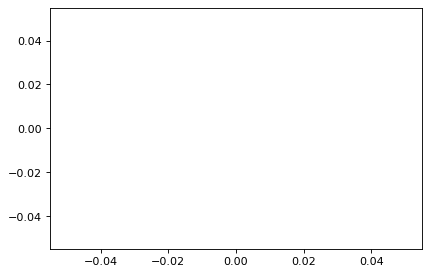

1


ValueError: x and y must have length at least 2.

In [63]:
plt.scatter(asc_rr1, spark_rr1, color="green")
plt.scatter(asc_rr2, spark_rr2, color='red')
plt.show()
print(len(asc_rr))
pearsonr(asc_rr, spark_rr)

In [ ]:
1 0.1

In [ ]:
x + y = 

In [ ]:
1.05 0.05